In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, mean_squared_error, confusion_matrix, RocCurveDisplay, roc_auc_score
from sklearn.utils import resample



# Prediction Experiment
Try to predict variable from all the others.

## Feature Selection
We use a lasso regressor to find a set of features for each variable we try to predict.

In [53]:
echo_reports = False

if echo_reports:
    preprocessed_normal_cohort_csv_path = "../../../preprocessed_normal_cohort_echo_reports.csv"
    df = pd.read_csv(preprocessed_normal_cohort_csv_path)
    df = df.drop('Unnamed: 0', axis=1)
else:
    echo_and_clinical_path = "../../../normal_cohort_echo_reports_and_clinical_variables.csv"
    df = pd.read_csv(echo_and_clinical_path)
    df = df.drop(["Pat_ResearchID", "Unnamed: 0", "echo_report", "clinical_variables"], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23992 entries, 0 to 23991
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Groesse_Echokardiographie           5656 non-null   float64
 1   Gewicht_Echokardiographie           5656 non-null   float64
 2   BMI                                 5651 non-null   float64
 3   Echoqualitaet                       5455 non-null   object 
 4   Mitralklappe                        5665 non-null   object 
 5   Aortenklappe                        5658 non-null   object 
 6   Aorta                               5339 non-null   object 
 7   Trikuspidalklappe                   5664 non-null   object 
 8   Pulmonalklappe                      5651 non-null   object 
 9   VenaCavaInferior                    1595 non-null   object 
 10  RechterVorhof                       5658 non-null   object 
 11  RechterVentrikel                    5655 

In [41]:
obv_dependencies_from_predictions = [["Groesse_Echokardiographie", "Gewicht_Echokardiographie", "BMI"],
                        ["Septum", "Hinterwand", "LVMMI", "rTh"],
                        ["LVMMI", "EDD", "rTh"],
                        ["LV_Fuellung", "EF", "rTh"],
                        ["EF", "EDV", "ESV", "EDD", "ESD_M_Mode"]]

obv_dependencies_from_correlation = [["Groesse_Echokardiographie", "Gewicht_Echokardiographie", 
                                      "BMI", "EDV", "ESV", "EDD", "ESD_M_Mode", "ESD", "Septum" , 
                                      "Hinterwand", "LV_Fuellung", "EF", "rTh"]]

clinical_variables = ["HbA1c n.NGSP", "Kalium", "Natrium", "eGFR (Krea) CKD-EPI",
                    "Kreatinin", "NT-proBNP", "TSH, basal", "Gewicht", "Grösse",
                    "Lymphozyten", "Thrombozyten", "Leukocytes", "Hemoglobin",
                    "Monozyten", "hsCRP", "Neutrophile", "CK", "Harnsäure",
                    "Alk. Phosphatase", "Ferritin",
                    "AST (GOT)Aspartat-Aminotransferase", "Troponin",
                    "ALT (GPT)Alanin-Aminotransferase", "Albumin", "Harnstoff",
                    "Bilirubin, total", "Transferrin Saturation", "Transferrin",
                    "D-Dimers", "Bicarbonat", "Laktat"]

In [50]:


# LR: Linear Regression (Lasso), RF: Random Forest Regression
model_type = "LR"
predict_values_from_echo_only = True
polynomial_feature_transform = True
use_obv_dependencies = False
subsample = True

results = []
num_rows = df.shape[0]
# upsample minority classes to ca. this ratio
upsample_ratio = 0.1
LR_alpha = 10 if polynomial_feature_transform else 0.1
use_obv_depenendencies_from_predictions = True

# Map Categorical columns to pd Categorical
numerical_df = df.copy()
mapping = {}
for X_col in numerical_df.columns:
    series = numerical_df[X_col]
    if series.dtype == 'object':
        numerical_df[X_col] = pd.Categorical(numerical_df[X_col])
        column_mapping = dict(enumerate(numerical_df[X_col].cat.categories))
        mapping[X_col] = column_mapping
        numerical_df[X_col] = numerical_df[X_col].cat.codes


for column in df.columns:
    if not echo_reports and not column in clinical_variables:
        continue

    if echo_reports and not use_obv_dependencies and df[column].dtype == 'object':
        continue
   
    print(column)
    # use the column to predict as y and remove from X
    X = numerical_df.drop(column,axis=1).copy()
    y = numerical_df[column].copy()

    # impute NaN values with mode
    for X_column in X.columns:
        X_column_mode = X[X_column].mode().values[0]
        X[X_column] = X[X_column].fillna(X_column_mode)

    
    # only use columns where y is not nan
    non_nan_y_indices = y.notnull()
    non_nan_cat_y_indices = y != -1
    X = X[non_nan_y_indices & non_nan_cat_y_indices]
    y = y[non_nan_y_indices & non_nan_cat_y_indices]
    #print("Dropped {} rows (NaN in y)".format(non_nan_y_indices.shape[0]-non_nan_y_indices.value_counts()[True]))


    # Map Categorical columns to pd Categorical
    mapping = {}
    for X_col in X.columns:
        series = X[X_col]
        if series.dtype == 'object':
            print(column, " is string")
            X[X_col] = pd.Categorical(X[X_col])
            column_mapping = dict(enumerate(X[X_col].cat.categories))
            mapping[X_col] = column_mapping
            X[X_col] = X[X_col].cat.codes

            # ignore if only one class is present in the dataa
            if X[X_col].unique().shape[0] == 1:
                print("Only one class for ", column)
                continue

    # remove obvius dependencies from X
    if not use_obv_dependencies:
        obv_dependencies = obv_dependencies_from_predictions if use_obv_depenendencies_from_predictions else obv_dependencies_from_correlation
        for dependency in obv_dependencies:
            if column in dependency:
                for dependent_column in dependency:
                    if dependent_column in list(X.columns):
                        X = X.drop(columns=dependent_column)
    

    # predict all variables from echo report data only (if set)
    if predict_values_from_echo_only:
        if column in clinical_variables:
            clinical_variables.remove(column)
            X = X.drop(columns=clinical_variables)
            clinical_variables.append(column)
        elif not echo_reports:  
            X = X.drop(columns=clinical_variables)


    # find value distribution for rebalancing
    original_value_counts = np.unique(y, return_counts=True)
    original_value_counts = list(zip(original_value_counts[0], original_value_counts[1]))

    # split into train and test, keep value distribution in train and test if y is string column (which are imbalanced)
    if df[column].dtypes == 'object':
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        except ValueError:
            # some variables only have 1 vlaue for a class which is noot enought for stratification
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # upsample minority class in training data for string columns
    sampling_factors = {}
    balanced_X_train = pd.DataFrame()
    balanced_y_train = pd.Series(dtype='object')
    
    balanced_X_test = pd.DataFrame()
    balanced_y_test = pd.Series(dtype='object')

    if df[column].dtypes == 'object':
        train_value_counts = np.unique(y_train, return_counts=True)
        train_value_counts = list(zip(train_value_counts[0], train_value_counts[1]))

        min_count = min(train_value_counts, key=lambda x: x[1])[1] 
        min_count = 30 if min_count < 30 else min_count
        test_min_count = np.unique(y_test, return_counts=True)[1].min()

        # dont do anything more if theres only one class
        if len(train_value_counts) == 1:
            continue

        # upsample each value below the upsample ratio count, in order for the value to make up at least 10% of the training data
        for [value, count] in train_value_counts:
            if not subsample:
            # upsample minority classes
                if count / num_rows < upsample_ratio:
                    value_y_train = y_train[y_train == value]
                    value_X_train = X_train[y_train == value]
                    upsampled_value_y_train, upsampled_value_X_train = resample(value_y_train, value_X_train, replace=True, n_samples=int(num_rows*upsample_ratio), random_state=42)
                    balanced_X_train = pd.concat((balanced_X_train, upsampled_value_X_train))
                    balanced_y_train = pd.concat((balanced_y_train, upsampled_value_y_train))
                    sampling_factors[value] = round(upsampled_value_y_train.shape[0] / value_y_train.shape[0], 2)

                else:
                    balanced_y_train = pd.concat((balanced_y_train, y_train[y_train == value]))
                    balanced_X_train = pd.concat((balanced_X_train, X_train[y_train == value])) 
                    sampling_factors[value] = 1

        
    
            else :
            # subsample majority class

                if count >= min_count:
                    value_y_train = y_train[y_train == value]
                    value_X_train = X_train[y_train == value]
                    subsampled_value_y_train, subsampled_value_X_train = resample(value_y_train, value_X_train, replace=False, n_samples=min_count, random_state=42)
                    balanced_X_train = pd.concat((balanced_X_train, subsampled_value_X_train))
                    balanced_y_train = pd.concat((balanced_y_train, subsampled_value_y_train))
                    sampling_factors[value] = round(subsampled_value_y_train.shape[0] / value_y_train.shape[0], 2)

                    value_y_test = y_test[y_test == value]
                    value_X_test = X_test[y_test == value]
                    subsampled_value_y_test, subsampled_value_X_test = resample(value_y_test, value_X_test, replace=False, n_samples=test_min_count, random_state=42)
                    balanced_X_test = pd.concat((balanced_X_test, subsampled_value_X_test))
                    balanced_y_test = pd.concat((balanced_y_test, subsampled_value_y_test))
                else:
                    balanced_y_train = pd.concat((balanced_y_train, y_train[y_train == value]))
                    balanced_X_train = pd.concat((balanced_X_train, X_train[y_train == value])) 
                    sampling_factors[value] = 1

                    balanced_X_test = pd.concat((balanced_X_test, X_test[y_test == value]))
                    balanced_y_test = pd.concat((balanced_y_test, y_test[y_test == value]))

        if subsample:
            X_test = balanced_X_test
            y_test = balanced_y_test

        new_value_counts = np.unique(balanced_y_train, return_counts=True)
        new_value_counts = list(zip(new_value_counts[0], new_value_counts[1]))
    
    # add quadratic features
    poly_features = PolynomialFeatures(degree=2)

    #score model
    if df[column].dtypes == 'object':

        if polynomial_feature_transform:
            balanced_X_train = poly_features.fit_transform(balanced_X_train)
            X_test = poly_features.transform(X_test)
            new_feature_names = poly_features.get_feature_names_out(X.columns)
            balanced_X_train = pd.DataFrame(balanced_X_train, columns=new_feature_names)
            X_test = pd.DataFrame(X_test, columns=new_feature_names)

        if model_type == "RF":
            model = RandomForestClassifier(random_state=42)
            model.fit(balanced_X_train, balanced_y_train)

            prediction = model.predict(X_test)
            accuracy = accuracy_score(y_test, prediction)
            balanced_accuracy = balanced_accuracy_score(y_test, prediction)

            test_value_counts = np.unique(y_test, return_counts=True)
            test_value_counts = list(zip(test_value_counts[0], test_value_counts[1]))

            probabilities = model.predict_proba(X_test)

            results.append({
                "column": column,
                "column_std": None,
                "mse": None,
                "mse_avg_ratio": None,
                "mse_std_ratio": None,
                "test_value_counts": test_value_counts,
                "train_value_counts": new_value_counts,
                "original_value_counts": original_value_counts,
                "accuracy": accuracy,
                "balanced_accuracy": balanced_accuracy,
                "upsampling_factors": sampling_factors,
                "feature_importances": model.feature_importances_,
                "feature_names": model.feature_names_in_
            })

            # store AUC ROC plot
            try:
                RocCurveDisplay.from_estimator(model, X_test, y_test)
                plt.savefig("./roc_plots/{}_{}__poly={}_obvDep={}_echoOnly={}_subsampled={}".format(column, model_type, polynomial_feature_transform, use_obv_dependencies, echo_reports, subsample))
            except ValueError:
                print("Because of multiclass no ROC plot for ", column)
            
             # store confusion matrix
            pd.DataFrame(confusion_matrix(y_test, prediction)).to_csv("./confusion_matrices/{}_{}__poly={}_obvDep={}_echoOnly={}_subsample={}".format(column, model_type, polynomial_feature_transform, use_obv_dependencies, echo_reports, subsample))
   

        elif model_type == "LR" and (subsample or not polynomial_feature_transform):
            
            model = LogisticRegression(penalty="l1", C=1/LR_alpha, max_iter=10000, solver="liblinear", random_state=42)
            model.fit(balanced_X_train, balanced_y_train)

            prediction = model.predict(X_test)
            accuracy = accuracy_score(y_test, prediction)
            balanced_accuracy = balanced_accuracy_score(y_test, prediction)

            test_value_counts = np.unique(y_test, return_counts=True)
            test_value_counts = list(zip(test_value_counts[0], test_value_counts[1]))

            probabilities = model.predict_proba(X_test)
                
            results.append({
                "column": column,
                "column_std": None,
                "mse": None,
                "mse_avg_ratio": None,
                "mse_std_ratio": None,
                "test_value_counts": test_value_counts,
                "train_value_counts": new_value_counts,
                "original_value_counts": original_value_counts,
                "accuracy": accuracy,
                "balanced_accuracy": balanced_accuracy,
                "upsampling_factors": sampling_factors,
                "feature_importances":  np.sum(np.abs(model.coef_), axis=0)/np.sum(np.sum(np.abs(model.coef_), axis=0)),
                "feature_names": model.feature_names_in_
            })

            # store AUC ROC plot
            try:
                RocCurveDisplay.from_estimator(model, X_test, y_test)
                plt.savefig("./roc_plots/{}_{}__poly={}_obvDep={}_echoOnly={}_subsampled={}".format(column, model_type, polynomial_feature_transform, use_obv_dependencies, echo_reports, subsample))
            except ValueError:
                print("Because of multiclass no ROC plot for ", column)
            # store confusion matrix
            pd.DataFrame(confusion_matrix(y_test, prediction)).to_csv("./confusion_matrices/{}_{}__poly={}_obvDep={}_echoOnly={}_subsample={}".format(column, model_type, polynomial_feature_transform, use_obv_dependencies, echo_reports, subsample))
   
    else:
        # do regression

        if polynomial_feature_transform:
            X_train = poly_features.fit_transform(X_train)
            X_test = poly_features.transform(X_test)
            new_feature_names = poly_features.get_feature_names_out(X.columns)
            X_train = pd.DataFrame(X_train, columns=new_feature_names)
            X_test = pd.DataFrame(X_test, columns=new_feature_names)

        if model_type == "RF":
            model = RandomForestRegressor(random_state=42)
            model.fit(X_train, y_train)
                
            prediction = model.predict(X_test)

            mse = mean_squared_error(y_test, prediction)
            mse_ratio = mse / np.average(y_test)
            column_std = y.std()
            mse_std_ratio = mse / column_std

            results.append({
                "column": column,
                "column_std": y.std(),
                "mse": mse,
                "mse_avg_ratio": mse_ratio,
                "mse_std_ratio": mse_std_ratio,
                "test_value_counts": None,
                "train_value_counts": None,
                "original_value_counts": None,
                "accuracy": None,
                "balanced_accuracy": None,
                "upsampling_factors": None,
                "feature_importances": model.feature_importances_,
                "feature_names": model.feature_names_in_
            })

        elif model_type == "LR":
            model = Lasso(alpha=LR_alpha, max_iter=100000 ,random_state=42)
            model.fit(X_train, y_train)
                
            prediction = model.predict(X_test)

            mse = mean_squared_error(y_test, prediction)
            mse_ratio = mse / np.average(y_test)
            column_std = y.std()
            mse_std_ratio = mse / column_std

            results.append({
                "column": column,
                "column_std": y.std(),
                "mse": mse,
                "mse_avg_ratio": mse_ratio,
                "mse_std_ratio": mse_std_ratio,
                "test_value_counts": None,
                "train_value_counts": None,
                "original_value_counts": None,
                "accuracy": None,
                "balanced_accuracy": None,
                "upsampling_factors": None,
                "feature_importances": np.abs(model.coef_)/np.sum(np.abs(model.coef_)),
                "feature_names": model.feature_names_in_
            })

        # store predictions
        pd.DataFrame({"y_test": y_test, "prediction": prediction}).to_csv("./predictions/{}_{}__poly={}_obvDep={}_echoOnly={}".format(column, model_type, polynomial_feature_transform, use_obv_dependencies, echo_reports))


results_df = pd.DataFrame.from_dict(results)


cutoff = 0.05
filename = "predictability_" + model_type
filename = "subsampled_" + filename if subsample else filename
filename = ("obv_deps_" + filename if use_obv_dependencies else "no_obv_deps_" + filename) if echo_reports else filename
filename = "poly_" + filename if polynomial_feature_transform else filename
filename = "echo_reports_" + filename if echo_reports else "clinical_vars_" + filename
results_df['important_features'] = results_df.apply(lambda row: [{feature_name, round(feature_importance,2)} for (feature_name, feature_importance) in zip(row['feature_names'],row['feature_importances']) if abs(feature_importance) > cutoff], axis=1)
results_df.round(4).to_csv(filename  + ".csv")
results_df.head(100)
    

Groesse_Echokardiographie
Gewicht_Echokardiographie
BMI
ESD_M_Mode
ESV
EDV
EF
Septum
Hinterwand
EDD
LVMMI
rTh
LV_Fuellung
HeartFrequency
BloodPressure_Systole
BloodPressure_Diastole


,column,column_std,mse,mse_avg_ratio,mse_std_ratio,test_value_counts,train_value_counts,original_value_counts,accuracy,balanced_accuracy,upsampling_factors,feature_importances,feature_names,important_features
0,Groesse_Echokardiographie,10.252959,80.321869,0.470922,7.834018,None,None,None,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, Echoqualitaet, Mitralklappe, Aortenklappe,...","[{Septum LVMMI, 0.21}, {0.16, Hinterwand LVMMI..."
1,Gewicht_Echokardiographie,19.355730,168.108242,2.174611,8.685193,None,None,None,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, Echoqualitaet, Mitralklappe, Aortenklappe,...","[{Septum LVMMI, 0.12}, {0.05, Septum HeartFreq..."
2,BMI,6.817832,23.172160,0.887583,3.398758,None,None,None,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, Echoqualitaet, Mitralklappe, Aortenklappe,...","[{0.13, Echoqualitaet BloodPressure_Systole}, ..."
3,ESD_M_Mode,5.303083,18.203493,0.522730,3.432625,None,None,None,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, Groesse_Echokardiographie, Gewicht_Echokar...","[{0.09, Groesse_Echokardiographie Gewicht_Echo..."
4,ESV,11.587515,66.801153,1.771115,5.764925,None,None,None,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, Groesse_Echokardiographie, Gewicht_Echokar...","[{0.19, Groesse_Echokardiographie VenaCavaInfe..."
5,EDV,23.471923,284.287087,2.988269,12.111793,None,None,None,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, Groesse_Echokardiographie, Gewicht_Echokar...","[{0.05, Groesse_Echokardiographie Echoqualitae..."
6,EF,4.728128,20.757539,0.342181,4.390224,None,None,None,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, Groesse_Echokardiographie, Gewicht_Echokar...","[{0.12, Groesse_Echokardiographie Echoqualitae..."
7,Septum,1.535185,1.628827,0.187535,1.060997,None,None,None,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, Groesse_Echokardiographie, Gewicht_Echokar...","[{0.05, Groesse_Echokardiographie Gewicht_Echo..."
8,Hinterwand,1.217400,1.121538,0.145265,0.921257,None,None,None,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, Groesse_Echokardiographie, Gewicht_Echokar...","[{0.41, Groesse_Echokardiographie VenaCavaInfe..."
9,EDD,4.902212,17.623263,0.376235,3.594961,None,None,None,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, Groesse_Echokardiographie, Gewicht_Echokar...","[{0.24, Groesse_Echokardiographie Echoqualitae..."


Find the right cutoff value

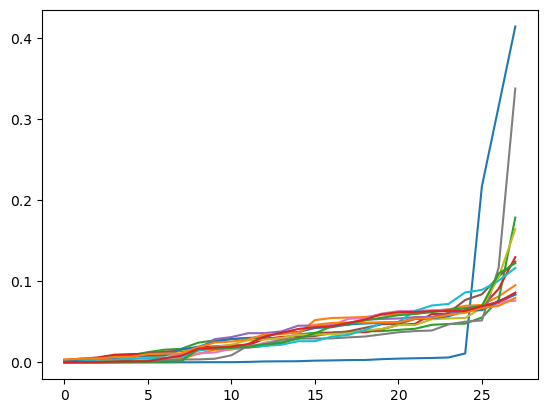

In [130]:
for index, row in results_df.iterrows():
    feature_importances = row['feature_importances'].copy()
    feature_importances.sort()
    plt.plot(feature_importances)

plt.show()

Code to consolidate results for model comparison.

In [63]:
no_obvious_dependencies = True
echo_reports_only = False

modelnames = ["poly_LR", "LR", "poly_RF", "RF"]

if echo_reports_only and no_obvious_dependencies and not subsample:
    filenames = ["echo_reports_poly_no_obv_deps_predictability_LR.csv",
                "echo_reports_no_obv_deps_predictability_LR.csv",
                "echo_reports_poly_no_obv_deps_predictability_RF.csv",
                "echo_reports_no_obv_deps_predictability_RF.csv"]
    comparison_name = "echo_reports_no_obv_deps_comparison.csv"
    
elif echo_reports_only and not no_obvious_dependencies and not subsample:
    filenames = ["echo_reports_poly_obv_deps_predictability_LR.csv",
                "echo_reports_obv_deps_predictability_LR.csv",
                "echo_reports_poly_obv_deps_predictability_RF.csv",
                "echo_reports_obv_deps_predictability_RF.csv"]
    comparison_name = "echo_reports_obv_deps_comparison.csv"

elif echo_reports_only and no_obvious_dependencies and subsample:
    filenames = ["echo_reports_poly_no_obv_deps_subsampled_predictability_LR.csv",
                "echo_reports_no_obv_deps_subsampled_predictability_LR.csv",
                "echo_reports_poly_no_obv_deps_subsampled_predictability_RF.csv",
                "echo_reports_no_obv_deps_subsampled_predictability_RF.csv"]
    comparison_name = "echo_reports_no_obv_deps_subsampled_comparison.csv"

elif not echo_reports_only:
    filenames = ["clinical_vars_poly_predictability_LR.csv",
                "clinical_vars_predictability_LR.csv",
                "clinical_vars_poly_predictability_RF.csv",
                "clinical_vars_predictability_RF.csv",]
    comparison_name = "clinical_vars_comparison.csv"


comparison_df = pd.DataFrame()
for idx, filename in enumerate(filenames):
    curr_df = pd.read_csv(filename)
    measures = pd.DataFrame(columns=["mse/accuracy_" + modelnames[idx], "mseToStdRatio/balancedAccuracy_" + modelnames[idx]])
    measures[["column","mse/accuracy_" + modelnames[idx], "mseToStdRatio/balancedAccuracy_" + modelnames[idx]]] = curr_df.apply(lambda row: pd.Series([row["column"], row["mse"], row["mse_std_ratio"]]) if pd.isnull(row["accuracy"]) else pd.Series([row["column"], row["accuracy"], row["balanced_accuracy"]]), axis=1)
    comparison_df = pd.concat((comparison_df, measures), axis=1)
print("saving: " + comparison_name)
comparison_df.to_csv(comparison_name)



saving: clinical_vars_comparison.csv


Test if the correlated variable eGFR (Krea) CKD-EPI cant be predicted better.

In [62]:
y = df["eGFR (Krea) CKD-EPI"]
X = df.drop(["eGFR (Krea) CKD-EPI"], axis=1)
X = df.drop(clinical_variables, axis=1)


# fill nan values with mode
for X_column in X.columns:
    X_column_mode = X[X_column].mode().values[0]
    X[X_column] = X[X_column].fillna(X_column_mode)


# remove rows with nan values in y
non_nan_y_indices = y.notnull()
non_nan_cat_y_indices = y != -1
X = X[non_nan_y_indices & non_nan_cat_y_indices]
y = y[non_nan_y_indices & non_nan_cat_y_indices]
print(X.shape)

# convert categorical values to numbers
for X_col in X.columns:
        series = X[X_col]
        if series.dtype == 'object':
            X[X_col] = pd.Categorical(X[X_col])
            X[X_col] = X[X_col].cat.codes



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=1000, max_depth=20, random_state=42)

model.fit(X_train, y_train)
prediction = model.predict(X_test)

mse = mean_squared_error(y_test, prediction)
mse_ratio = mse / np.average(y_test)
column_std = y.std()
mse_std_ratio = mse / column_std

print("mse: " + str(mse))
print("mse ratio: " + str(mse_ratio))
print("mse std ratio: " + str(mse_std_ratio))

(6935, 29)
mse: 793.3348595774958
mse ratio: 8.51022792490206
mse std ratio: 28.107774210540537
